In [5]:
import os
import numpy as np
import pytesseract
import cv2
import matplotlib.pyplot as plt
import json
from utils import show, convert,  add_location, preprocessing
# debug 
isDebugMode = False

def read_templates(directory_path):
    templates = []
    files = []
    
    for f in os.listdir(directory_path):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            # 템플릿 이미지를 그레이스케일로 읽어오기
            template = cv2.imread(os.path.join(directory_path, f))
            # 이진화 수행
            template_threshold = preprocessing(template)   

            # 이진화된 이미지를 템플릿 리스트에 추가
            templates.append(template_threshold)

            name, ext = os.path.splitext(f)
            files.append(name)
    
    return templates, files
def debug(msg):
    if isDebugMode:
        print(msg)

def debugShow(template):
    if isDebugMode:
        show(template)

# 디렉토리 경로
directory_path = "template_img/"
templates, files = read_templates(directory_path)

# 실행파일 위치저장
pytesseract.pytesseract.tesseract_cmd = "C:/Tesseract-OCR/tesseract.exe"

class OCR:
    def __init__(self):
        pass
 
    def get(self, img, mode):
        
        debugShow(img)
        # 전처리 
        if mode == 'kor':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
        elif mode == 'number':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif mode == 'eng':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            roi = roi_gray
       
        elif mode == 'img':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
        # debugShow(roi)
        # 이미지 스캔          
        if mode == 'kor':
            text = pytesseract.image_to_string(roi, lang='kor+eng --psm 6')
            return text
        elif mode == 'number':
            text = ''.join(filter(str.isdigit, pytesseract.image_to_string(roi, config='--psm 6')))
            return text
        elif mode == 'eng':
            text = ''.join(filter(str.isalpha, pytesseract.image_to_string(roi, config='eng --oem')))
            return text     
        elif mode == 'img':
            text = pytesseract.image_to_string(roi, lang='kor+eng --psm 6')
            return text
        else:
            return "Invalid language type"
 


In [6]:
# 클래스 인스턴스 생성
ocr = OCR()

# 위치 정보를 추가
locationInfos = []
add_location(locationInfos, 'no', 292, 163, 330, 185, 'number')
add_location(locationInfos, 'command', 356, 168, 1250, 210, 'kor')
add_location(locationInfos, 'name', 348, 135, 604, 169, 'eng')
add_location(locationInfos, 'command', 356, 168, 1250, 210, 'searchTemplate') 


In [7]:
## 메인 함수
def main(img_name): 

    # 이미지 읽기
    img = cv2.imread(img_name)

    # 이미지 있는지 체크 하고 없으면 그다음 이미지로 넘어감
    if img is None:
        print(f"이미지 {img_name} 을 찾을 수 없습니다.")
        return
    
    # 이미지 크기 확인
    # height, width, _ = img.shape

    # 결과값 dict
    results = {}



    # 위치 배열을 순회하며 이미지에서 자르고 텍스트 읽어오기
    for locationIndex, locationInfo in enumerate(locationInfos):
        name, mode = locationInfo['name'], locationInfo['mode']
        # 이미지에서 특정 구간 자르기 
        img_roi = img[locationInfo['y1']:locationInfo['y2'], locationInfo['x1']:locationInfo['x2']]
        
        item = results.get(name, {})
        
        if mode != 'searchTemplate':
            item[mode] = ocr.get(img_roi, mode) # OCR 실행    
            
        if mode == 'searchTemplate':

            roi_threshold = preprocessing(img_roi) 
            debugShow(roi_threshold)
            
            # B1 템플릿 매칭 수행
            found_locations = []
            # debug("----------------------------------")
            for tidx, template in enumerate(templates):   
                
                # B1-1 템플릿 매칭 수행, 유사도 N% 이상인 위치 찾기
                result = cv2.matchTemplate(roi_threshold, template, cv2.TM_CCOEFF_NORMED)
                ratio = 0.90 
                matched = np.where(result >= ratio) 
    
                debug(f"템플릿 {tidx} {files[tidx]}  {result.max()}") # 최대 유사도 출력
                if len(matched[0]) > 0:
                    if( isDebugMode ) :
                        debugShow(template)
                        debug(f"founded list : {files[tidx]} {len(matched[0])}개")
                    # 찾은 위치와 유사도를 함께 저장
                    for pt in zip(*matched[::-1]):
                        data = { 'x': pt[0], 'y': pt[1], 'ratio': "{:.6f}".format(result[pt[1], pt[0]]), name: files[tidx] } 
                        found_locations.append(data)  
                        # debug(f">  {data}")
                
                # debug("----------------------------------")

            # 정렬 배열에 x 순서대로
            found_locations = sorted(found_locations, key=lambda x: x['x'])
            debug(found_locations)
            if( isDebugMode ) :
                # 결과 이미지에 템플릿 위치 표시
                for found_location in found_locations:
                    print(found_location) 
                    h, w = template.shape 
                    x, y  = found_location['x'], found_location['y']
                    top_left = (x, y)
                    bottom_right = (x + w, y + h)
                    cv2.rectangle(img_roi, top_left, bottom_right, 255, 2)
            
            item[mode] = found_locations
        
        # 결과값 저장   
        print(item)
        results[name] = item
        
    # 결과값 출력 
    # print('결과')
    # print(results)
    # print(json.dumps(results,default=convert, indent=4, ensure_ascii=False))
 
    return results
                

['target/raven/tk_raven.mp4_20240227_074745.177.jpg', 'target/raven/tk_raven.mp4_20240227_074748.137.jpg', 'target/raven/tk_raven.mp4_20240227_074750.514.jpg', 'target/raven/tk_raven.mp4_20240227_074752.937.jpg', 'target/raven/tk_raven.mp4_20240227_074756.002.jpg', 'target/raven/tk_raven.mp4_20240227_074758.370.jpg', 'target/raven/tk_raven.mp4_20240227_074800.666.jpg', 'target/raven/tk_raven.mp4_20240227_074803.362.jpg', 'target/raven/tk_raven.mp4_20240227_074806.266.jpg', 'target/raven/tk_raven.mp4_20240227_074809.026.jpg', 'target/raven/tk_raven.mp4_20240227_074812.547.jpg', 'target/raven/tk_raven.mp4_20240227_074814.907.jpg', 'target/raven/tk_raven.mp4_20240227_074817.123.jpg', 'target/raven/tk_raven.mp4_20240227_074819.819.jpg', 'target/raven/tk_raven.mp4_20240227_074822.075.jpg', 'target/raven/tk_raven.mp4_20240227_074825.763.jpg', 'target/raven/tk_raven.mp4_20240227_074829.003.jpg', 'target/raven/tk_raven.mp4_20240227_074831.747.jpg', 'target/raven/tk_raven.mp4_20240227_074834.28

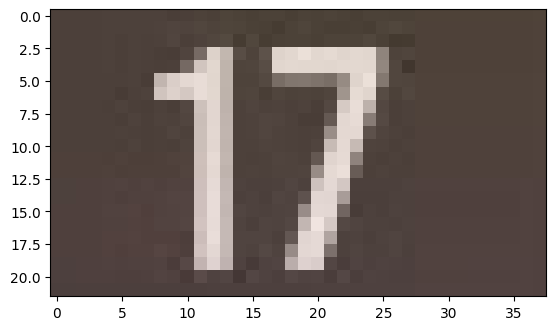

{'number': '7'}


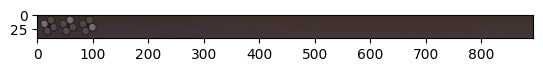

{'kor': ''}


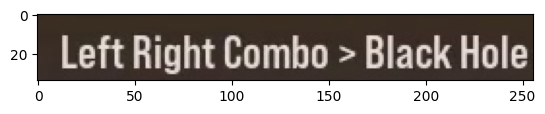

{'eng': 'LeftRightComboBlackHole'}


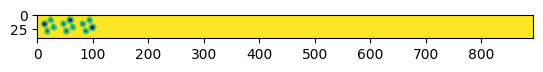

템플릿 0 ak  0.827384352684021
템플릿 1 ap  0.8772592544555664
템플릿 2 apk  0.8432372808456421
템플릿 3 arrow_2  0.4624137878417969
템플릿 4 arrow_3  0.4305691421031952
템플릿 5 arrow_3bold  0.32975488901138306
템플릿 6 arrow_4  0.4522412121295929
템플릿 7 arrow_4bold  0.2854665517807007
템플릿 8 arrow_6  0.4580898880958557
템플릿 9 arrow_6bold  0.29322221875190735
템플릿 10 arrow_7  0.5568518042564392
템플릿 11 arrow_9  0.5261886119842529
템플릿 12 bracketL  0.3800525665283203
템플릿 13 bracketR  0.3865010738372803
템플릿 14 bracketRoundL  0.399533748626709
템플릿 15 bracketRoundR  0.4065238833427429
템플릿 16 lk  0.7599978446960449
템플릿 17 lp  0.9147169589996338


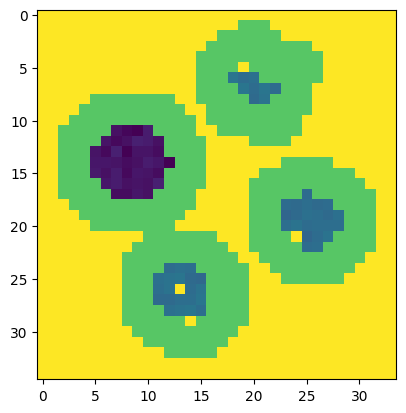

founded list : lp 1개
템플릿 18 rk  0.9150170683860779


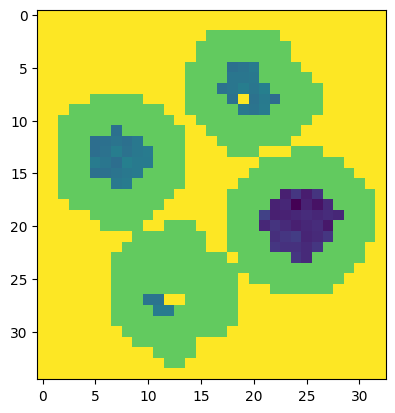

founded list : rk 1개
템플릿 19 rp  0.9170973896980286


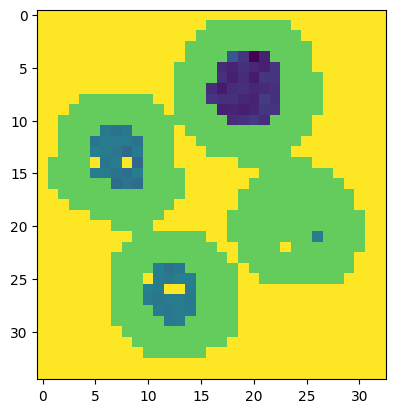

founded list : rp 1개
[{'x': 5, 'y': 3, 'ratio': '0.914717', 'command': 'lp'}, {'x': 40, 'y': 3, 'ratio': '0.917097', 'command': 'rp'}, {'x': 75, 'y': 3, 'ratio': '0.915017', 'command': 'rk'}]
{'x': 5, 'y': 3, 'ratio': '0.914717', 'command': 'lp'}
{'x': 40, 'y': 3, 'ratio': '0.917097', 'command': 'rp'}
{'x': 75, 'y': 3, 'ratio': '0.915017', 'command': 'rk'}
{'kor': '', 'searchTemplate': [{'x': 5, 'y': 3, 'ratio': '0.914717', 'command': 'lp'}, {'x': 40, 'y': 3, 'ratio': '0.917097', 'command': 'rp'}, {'x': 75, 'y': 3, 'ratio': '0.915017', 'command': 'rk'}]}


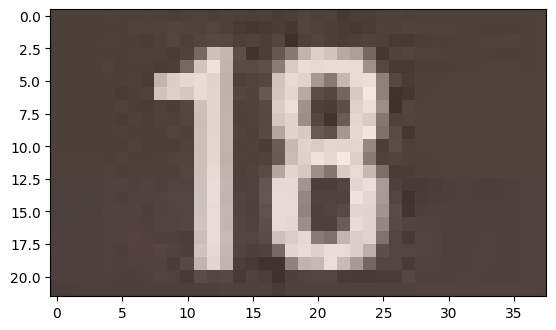

{'number': '18'}


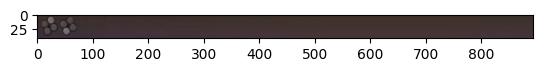

{'kor': ''}


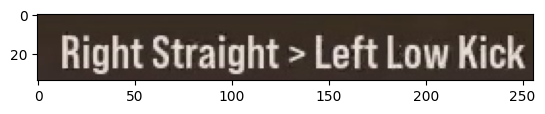

{'eng': 'RightStraightLeftLowKick'}


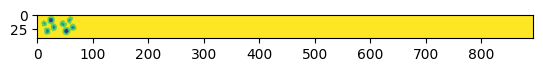

템플릿 0 ak  0.8360029458999634
템플릿 1 ap  0.816595196723938
템플릿 2 apk  0.8036730289459229
템플릿 3 arrow_2  0.496331125497818
템플릿 4 arrow_3  0.529449462890625
템플릿 5 arrow_3bold  0.3283446729183197
템플릿 6 arrow_4  0.438748300075531
템플릿 7 arrow_4bold  0.29639145731925964
템플릿 8 arrow_6  0.3349754810333252
템플릿 9 arrow_6bold  0.31360480189323425
템플릿 10 arrow_7  0.4991719126701355
템플릿 11 arrow_9  0.4704183340072632
템플릿 12 bracketL  0.304957777261734
템플릿 13 bracketR  0.3335588276386261
템플릿 14 bracketRoundL  0.38573557138442993
템플릿 15 bracketRoundR  0.40561074018478394
템플릿 16 lk  0.8919335007667542
템플릿 17 lp  0.6624158620834351
템플릿 18 rk  0.6625723838806152
템플릿 19 rp  0.8383283615112305
[]
{'kor': '', 'searchTemplate': []}


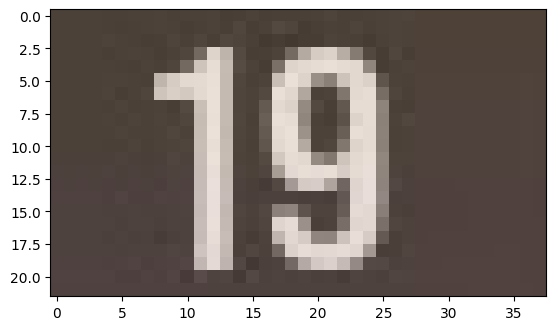

{'number': '19'}


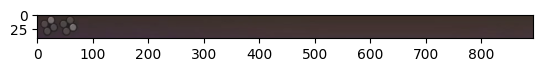

{'kor': ''}


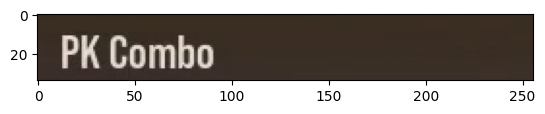

{'eng': 'PKCombo'}


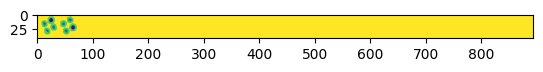

템플릿 0 ak  0.8317591547966003
템플릿 1 ap  0.8822292685508728
템플릿 2 apk  0.8396215438842773
템플릿 3 arrow_2  0.44503816962242126
템플릿 4 arrow_3  0.4096169173717499
템플릿 5 arrow_3bold  0.3320889174938202
템플릿 6 arrow_4  0.4404233992099762
템플릿 7 arrow_4bold  0.29320621490478516
템플릿 8 arrow_6  0.44721660017967224
템플릿 9 arrow_6bold  0.2932888865470886
템플릿 10 arrow_7  0.5527652502059937
템플릿 11 arrow_9  0.502853274345398
템플릿 12 bracketL  0.3890361487865448
템플릿 13 bracketR  0.3527563214302063
템플릿 14 bracketRoundL  0.41902637481689453
템플릿 15 bracketRoundR  0.4121549725532532
템플릿 16 lk  0.7315276861190796
템플릿 17 lp  0.7334714531898499
템플릿 18 rk  0.8978379368782043
템플릿 19 rp  0.8753571510314941
[]
{'kor': '', 'searchTemplate': []}


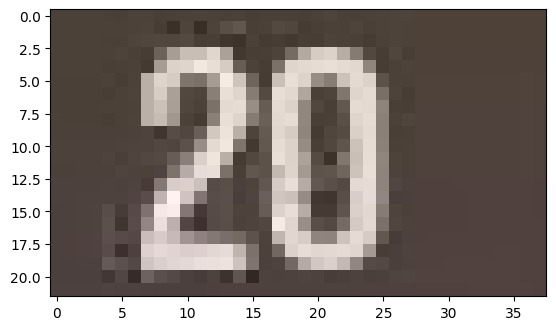

{'number': '20'}


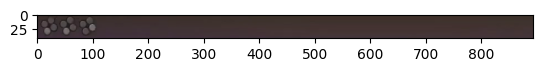

{'kor': ''}


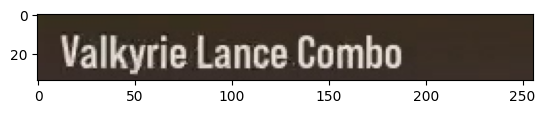

{'eng': 'ValkyrieLanceCombo'}


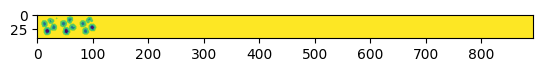

템플릿 0 ak  0.8630152344703674
템플릿 1 ap  0.7188518643379211
템플릿 2 apk  0.838165283203125
템플릿 3 arrow_2  0.5047358870506287
템플릿 4 arrow_3  0.503436267375946
템플릿 5 arrow_3bold  0.27776825428009033
템플릿 6 arrow_4  0.4617685079574585
템플릿 7 arrow_4bold  0.30469322204589844
템플릿 8 arrow_6  0.4354919493198395
템플릿 9 arrow_6bold  0.33599260449409485
템플릿 10 arrow_7  0.5634773373603821
템플릿 11 arrow_9  0.49569347500801086
템플릿 12 bracketL  0.3766205310821533
템플릿 13 bracketR  0.38732513785362244
템플릿 14 bracketRoundL  0.41175392270088196
템플릿 15 bracketRoundR  0.4303620755672455
템플릿 16 lk  0.9043024778366089


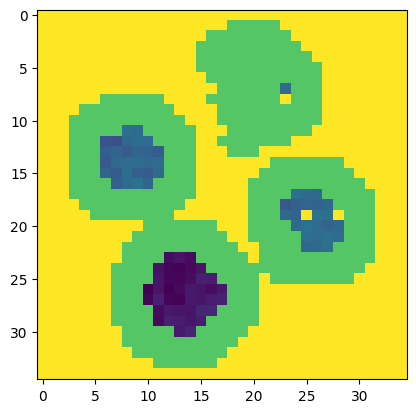

founded list : lk 1개
템플릿 17 lp  0.727756917476654
템플릿 18 rk  0.8838005065917969
템플릿 19 rp  0.6961153745651245
[{'x': 39, 'y': 3, 'ratio': '0.904302', 'command': 'lk'}]
{'x': 39, 'y': 3, 'ratio': '0.904302', 'command': 'lk'}
{'kor': '', 'searchTemplate': [{'x': 39, 'y': 3, 'ratio': '0.904302', 'command': 'lk'}]}


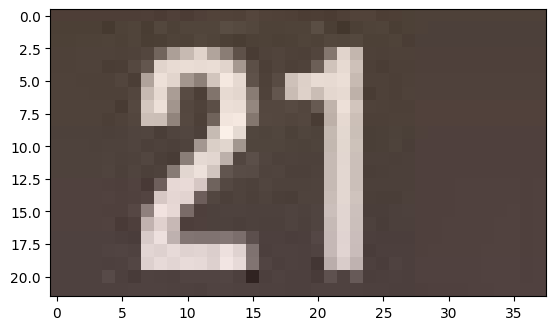

{'number': '21'}


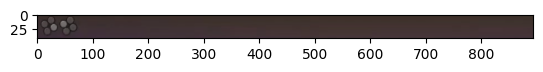

{'kor': ''}


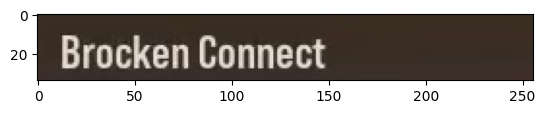

{'eng': 'BrockenConnect'}


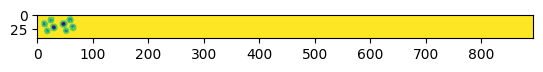

템플릿 0 ak  0.7654005885124207
템플릿 1 ap  0.8417741656303406
템플릿 2 apk  0.805674135684967
템플릿 3 arrow_2  0.45993468165397644
템플릿 4 arrow_3  0.44249048829078674
템플릿 5 arrow_3bold  0.2614237368106842
템플릿 6 arrow_4  0.4397607147693634
템플릿 7 arrow_4bold  0.2804185450077057
템플릿 8 arrow_6  0.4517732858657837
템플릿 9 arrow_6bold  0.2608191668987274
템플릿 10 arrow_7  0.4988110661506653
템플릿 11 arrow_9  0.4992142915725708
템플릿 12 bracketL  0.4055292308330536
템플릿 13 bracketR  0.3654042184352875
템플릿 14 bracketRoundL  0.4125678837299347
템플릿 15 bracketRoundR  0.43184569478034973
템플릿 16 lk  0.7034905552864075
템플릿 17 lp  0.888508141040802
템플릿 18 rk  0.8572012186050415
템플릿 19 rp  0.6932499408721924
[]
{'kor': '', 'searchTemplate': []}


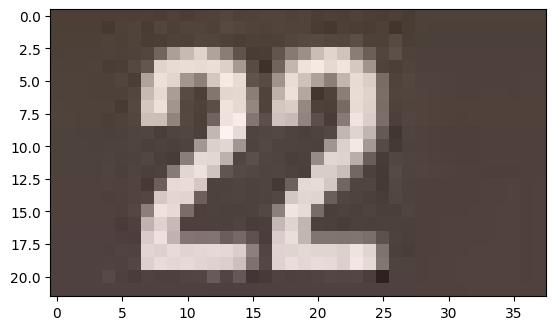

{'number': '22'}


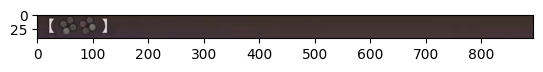

KeyboardInterrupt: 

In [8]:

# 이미지 폴더
img_dir = "target/raven/"

# 폴더안에 이미지 파일 리스트
img_names = [img_dir + f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
# 이미지 배열
# img_names = ["raven1.jpg", "raven2.jpg", "raven3.jpg", "raven4.jpg", "raven5.jpg", "raven6.jpg", "raven7.jpg", "raven8.jpg"]
print(img_names)
res = []
# 이미지 순회 main() 함수 실행
for img_name in img_names:
    res.append(main(img_name))

filename = 'raven.json'
with open(filename, 'w', encoding='utf-8') as make_file:
    json.dump(res, make_file, default=convert,  ensure_ascii=False, indent="\t")
